In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import plotly.express as px
import seaborn as sns
import requests
import datetime as dt
from datetime import datetime, timedelta


# Para machine learning
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from math import sqrt


#
import statsmodels
from statsmodels.tsa.stattools import adfuller, kpss    #verificar dados estacionários
from statsmodels.tsa.stattools import acf, pacf         #correlação
from statsmodels.tsa.seasonal import seasonal_decompose #Decomposição sazonal usando médias móveis.
from statsmodels.tsa.arima.model import ARIMA           #algoritmo arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Prophet
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import warnings
warnings.filterwarnings('ignore')

# SELECIONANDO PRECISAO DECIMAL NO PANDAS EM ZERO DECIMAIS
pd.set_option("display.precision", 2)


In [2]:

# Configurando variaveis iniciais

quantidade_paises = 10
periodo_longo = 50
periodo_analise = 25
periodo_curto = 5
periodo_lag = 7

initial_date = dt.date(1987,5,1)
yesterday = datetime.today() - dt.timedelta(days=1)
yesterday = yesterday.strftime('%Y-%m-%d')

url = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view'
html = requests.get(url).content
df_list = pd.read_html(html)
df_petroleo = df_list[2]
df_petroleo = df_petroleo[1:]
df_petroleo.columns = ["Data", "Preco"]
df_petroleo["Data"] = pd.to_datetime(df_petroleo["Data"], format='%d/%m/%Y')
df_petroleo["Preco"] = pd.to_numeric(df_petroleo["Preco"])/100
df_petroleo.index.name = "Data"
df_petroleo.index = df_petroleo["Data"]
print(df_petroleo)
#df_petroleo.to_csv('my data.csv')
df_petroleo.info()

                 Data  Preco
Data                        
2024-07-15 2024-07-15  86.42
2024-07-12 2024-07-12  87.35
2024-07-11 2024-07-11  86.49
2024-07-10 2024-07-10  86.55
2024-07-09 2024-07-09  86.48
...               ...    ...
1987-05-26 1987-05-26  18.63
1987-05-25 1987-05-25  18.60
1987-05-22 1987-05-22  18.55
1987-05-21 1987-05-21  18.45
1987-05-20 1987-05-20  18.63

[11213 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11213 entries, 2024-07-15 to 1987-05-20
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    11213 non-null  datetime64[ns]
 1   Preco   11213 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 262.8 KB


In [3]:
lista_anos = df_petroleo["Data"].astype(str).str[0:4].str.strip().drop_duplicates().to_list()
lista_anos.sort(reverse = True)

lista_anos_curto = lista_anos[:periodo_curto]

excluir_anos = lista_anos[periodo_longo:]
lista_anos_longo = lista_anos[:periodo_longo]
lista_analise = lista_anos[:periodo_analise]

lista_anos_curto.sort(reverse = False)
excluir_anos.sort(reverse = False)
lista_anos_longo.sort(reverse = False)

ano_recente = lista_anos_longo[-1]
primeiro_ano = lista_anos_longo[0]

print(lista_analise)
print(ano_recente, primeiro_ano)

['2024', '2023', '2022', '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007', '2006', '2005', '2004', '2003', '2002', '2001', '2000', '1999', '1998', '1997', '1996', '1995', '1994', '1993', '1992', '1991', '1990', '1989', '1988', '1987']
2024 1987


In [4]:
fig = px.line(df_petroleo, x='Data', y='Preco', title=f"Valor Diário Petroleo Brent (US$) ({lista_anos_longo[0]}-{ano_recente})")
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

In [5]:
df_petroleo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11213 entries, 2024-07-15 to 1987-05-20
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    11213 non-null  datetime64[ns]
 1   Preco   11213 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 262.8 KB


In [6]:
df = df_petroleo.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11213 entries, 2024-07-15 to 1987-05-20
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    11213 non-null  datetime64[ns]
 1   Preco   11213 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 262.8 KB


In [7]:
# Criacao de Dados para gerar insights

# lags de 1 a 7 dias do preço
for lag in range(1, 1 + periodo_lag):
    df[f"lag_{lag}"] = df["Preco"].shift(lag)

# média móvel de 7 dias do preço
df["media_movel"] = df["Preco"].shift(1).rolling(window=periodo_lag).mean()

# diferenças de preço entre os dias
df["diff"] = df["Preco"].shift(1).diff()

# componentes sazonais
df["month"] = df.index.month
df["day_of_week"] = df.index.dayofweek

# desvio padrão móvel do preço na janela de 7 dias
df["desvio_padrao"] = df["Preco"].shift(1).rolling(window=periodo_lag).std()

# variáveis de calendário
df["day"] = df.index.day
df["quarter"] = df.index.quarter
df["year"] = df.index.year

df = df.dropna()
df.info()
print(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11206 entries, 2024-07-04 to 1987-05-20
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Data           11206 non-null  datetime64[ns]
 1   Preco          11206 non-null  float64       
 2   lag_1          11206 non-null  float64       
 3   lag_2          11206 non-null  float64       
 4   lag_3          11206 non-null  float64       
 5   lag_4          11206 non-null  float64       
 6   lag_5          11206 non-null  float64       
 7   lag_6          11206 non-null  float64       
 8   lag_7          11206 non-null  float64       
 9   media_movel    11206 non-null  float64       
 10  diff           11206 non-null  float64       
 11  month          11206 non-null  int32         
 12  day_of_week    11206 non-null  int32         
 13  desvio_padrao  11206 non-null  float64       
 14  day            11206 non-null  int32         
 15  qu

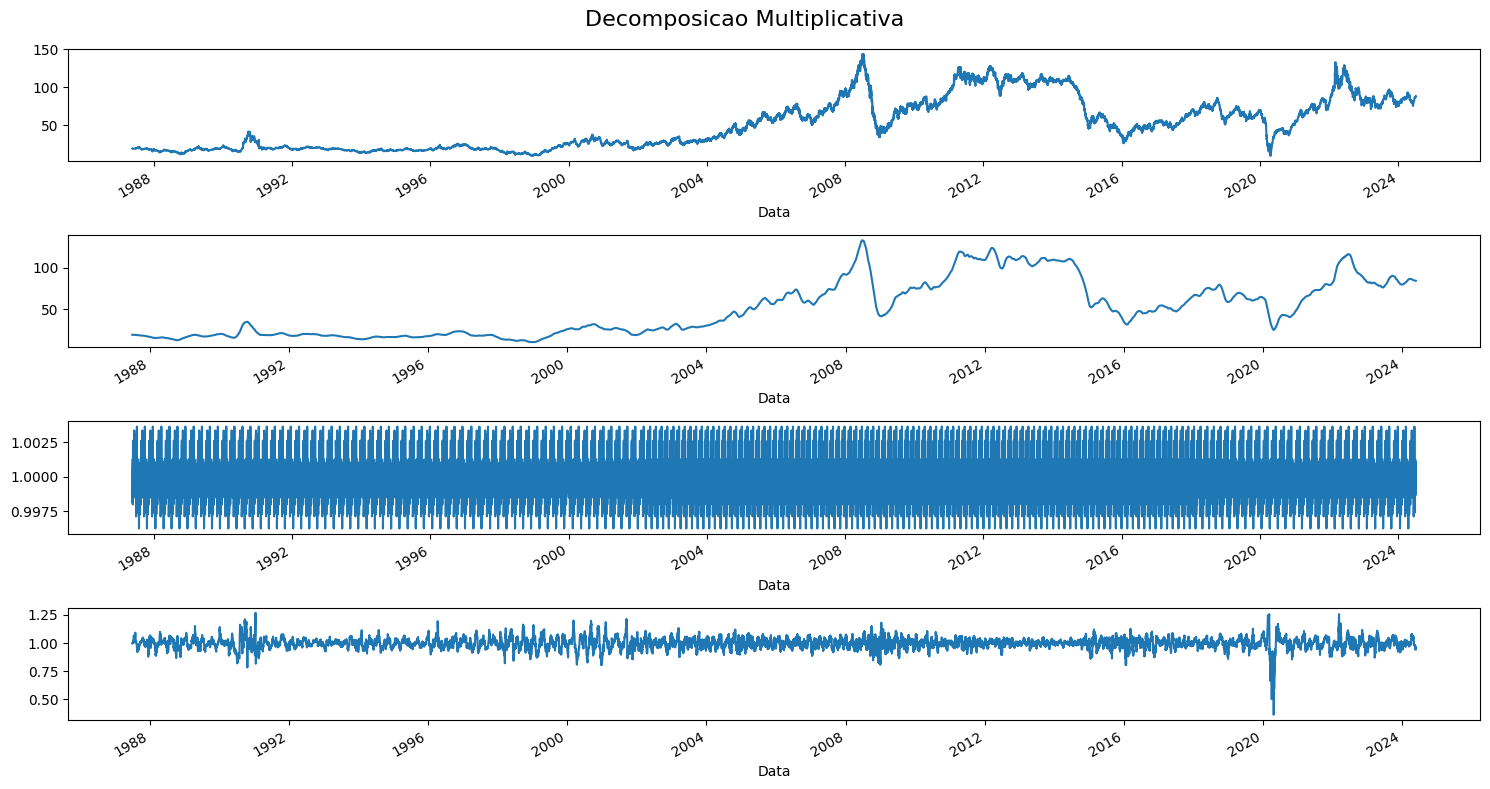

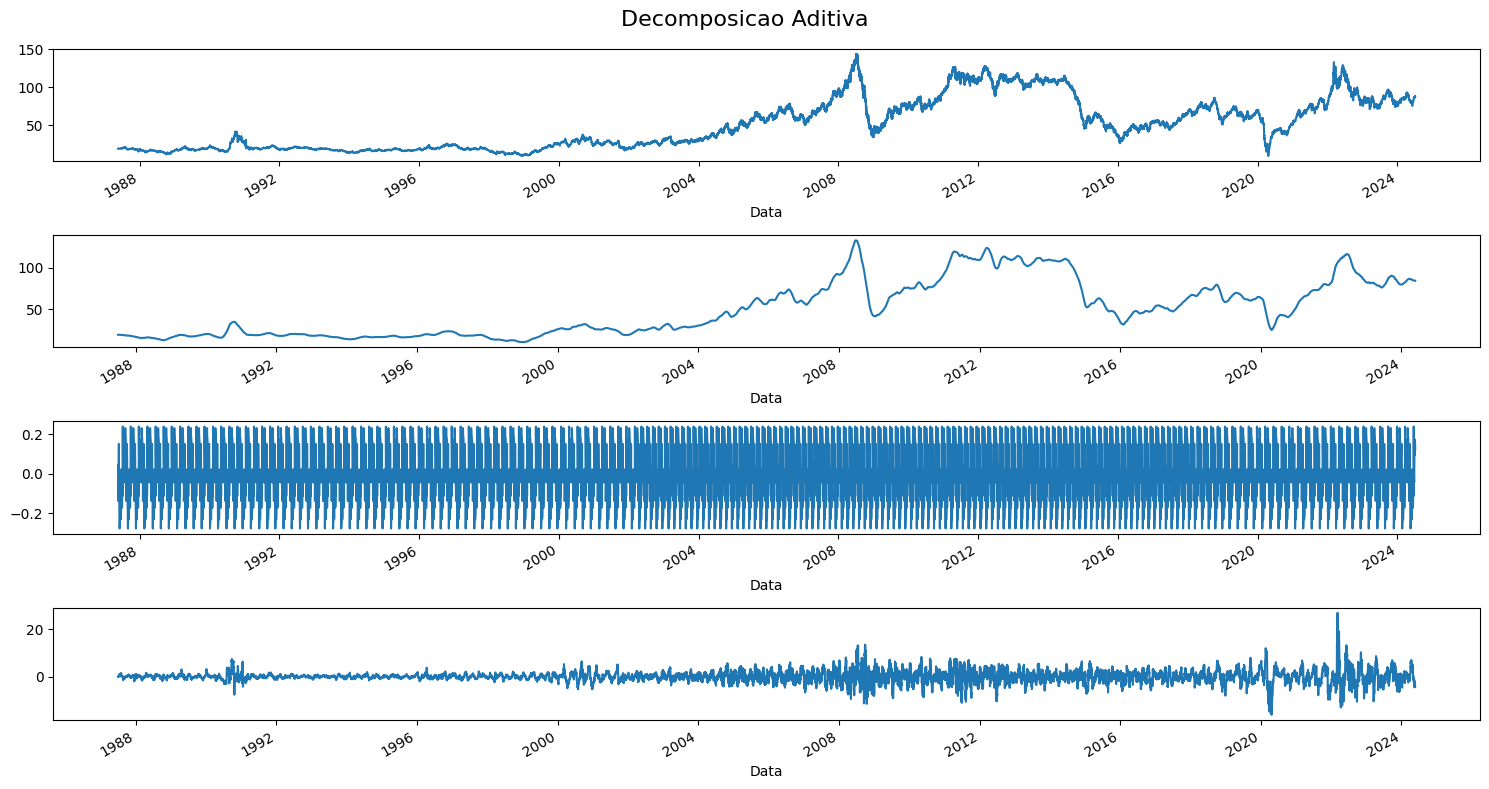

In [8]:
# Decomposicao Multiplicativa
decomposicao_multiplicativa = seasonal_decompose(df['Preco'], model='multiplicative', period=60)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
fig.suptitle('Decomposicao Multiplicativa', fontsize=16)
decomposicao_multiplicativa.observed.plot(ax=ax1) #serie real
decomposicao_multiplicativa.trend.plot(ax=ax2)    #tendencia
decomposicao_multiplicativa.seasonal.plot(ax=ax3) #sazonalisade
decomposicao_multiplicativa.resid.plot(ax=ax4)    #residuos
plt.tight_layout()

# Decomposicao aditiva
decomposicao_aditiva = seasonal_decompose(df['Preco'], model='additive', period=60)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
fig.suptitle('Decomposicao Aditiva', fontsize=16)
decomposicao_aditiva.observed.plot(ax=ax1) #serie real
decomposicao_aditiva.trend.plot(ax=ax2)    #tendencia
decomposicao_aditiva.seasonal.plot(ax=ax3) #sazonalisade
decomposicao_aditiva.resid.plot(ax=ax4)    #residuos
plt.tight_layout()
plt.show()

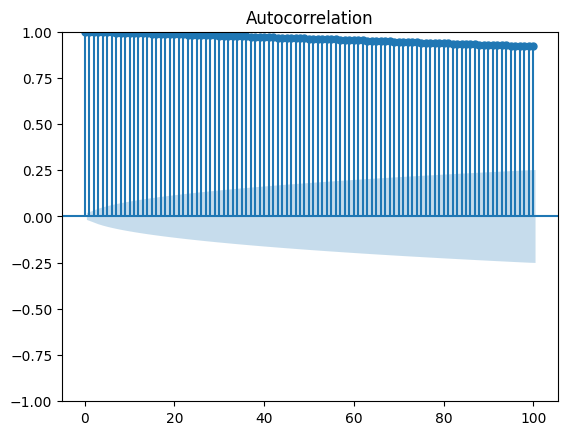

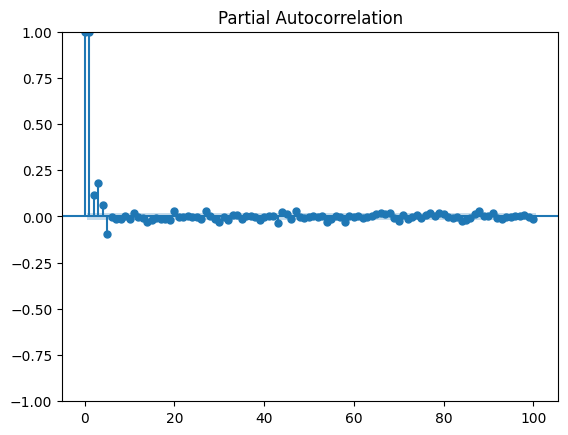

In [9]:
plot_acf(df['Preco'], lags=100)
plot_pacf(df['Preco'], lags=100)
plt.show()

            Preco  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  \
Data                                                                 
2024-07-04    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2024-07-03    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2024-07-02    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2024-07-01    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2024-06-28    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...   
1987-05-26  18.69  18.69  18.70  18.73  18.77  18.80  18.83  18.86   
1987-05-25  18.67  18.69  18.69  18.70  18.73  18.77  18.80  18.83   
1987-05-22  18.65  18.67  18.69  18.69  18.70  18.73  18.77  18.80   
1987-05-21  18.63  18.65  18.67  18.69  18.69  18.70  18.73  18.77   
1987-05-20  18.62  18.63  18.65  18.67  18.69  18.69  18.70  18.73   

            media_movel      diff  month  day_of_week  desvio_padrao    day  \
Data      

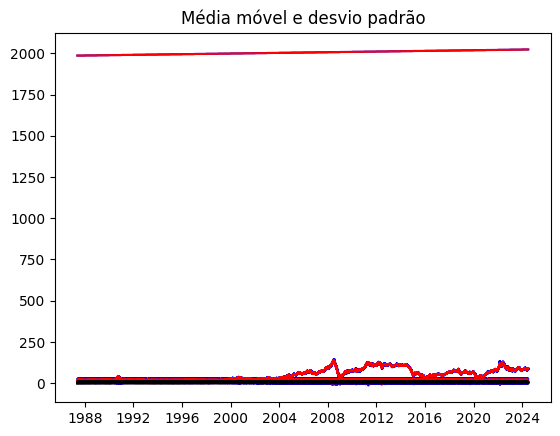

In [10]:


if 'Data' in df.columns:
    df['Data'] = pd.to_datetime(df['Data'])


if 'Data' in df.columns:
    df = df.set_index('Data')

media_movel_12_meses = df.rolling(window=12).mean()
desvio_12_meses = df.rolling(window=12).std()
print(media_movel_12_meses,desvio_12_meses)


#Plotando a média móvel
atual = plt.plot(df, color='blue', label='Valor Real')
media = plt.plot(media_movel_12_meses, color='red', label='Media Movel')
desvio = plt.plot(desvio_12_meses, color='black', label='Desvio Movel')

plt.title('Média móvel e desvio padrão')
plt.show(block=False)

In [11]:
# Teste de estacionariedade (Teste de Dickey Fuller, conhecido como Augmented Dickey Fuller test [ADF test])

adf_test = adfuller(df['Preco'])

print('ADF: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('')

if (adf_test[1] < 0.9):
  print("Valor p %f muito baixo --> provavelmente nao-estacionario" % adf_test[0])
else:
  print("Valor p %f alto --> provavelmente estacionario" % adf_test[0])
adf_test

ADF: -1.994587
p-value: 0.288951

Valor p -1.994587 muito baixo --> provavelmente nao-estacionario


(-1.9945873626555812,
 0.28895138337420895,
 31,
 11174,
 {'1%': -3.430935359125964,
  '5%': -2.86179869690675,
  '10%': -2.5669076992471047},
 39211.881393713185)

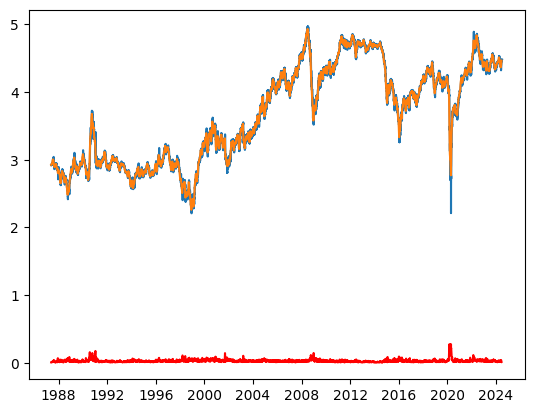

In [12]:
tendencia_movel_log = np.log(df["Preco"])
media_movel_curva = tendencia_movel_log.rolling(window=12).mean()
desvio_curva = tendencia_movel_log.rolling(window=12).std()

plt.plot(tendencia_movel_log)
plt.plot(media_movel_curva)
plt.plot(desvio_curva, color='red')

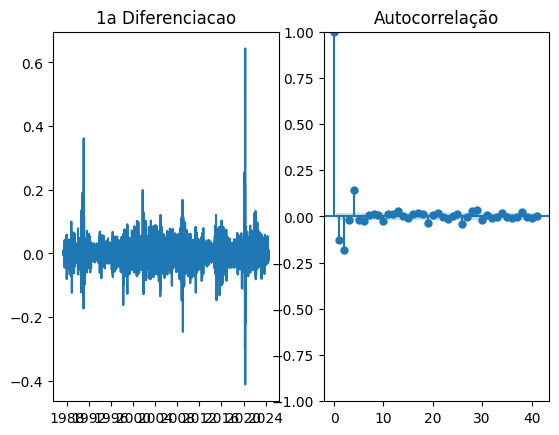

In [13]:
#diferencial_tendencia_movel_log = tendencia_movel_log.diff() # nao funcionou... ficou um ruido na primeira amostra...

diferencial_tendencia_movel_log = tendencia_movel_log -tendencia_movel_log.shift()
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(diferencial_tendencia_movel_log); ax1.set_title('1a Diferenciacao')
plot_acf(df["Preco"].diff().dropna(), ax=ax2, title='Autocorrelação')

plt.show()

In [14]:
diferencial_tendencia_movel_log.dropna(inplace=True)

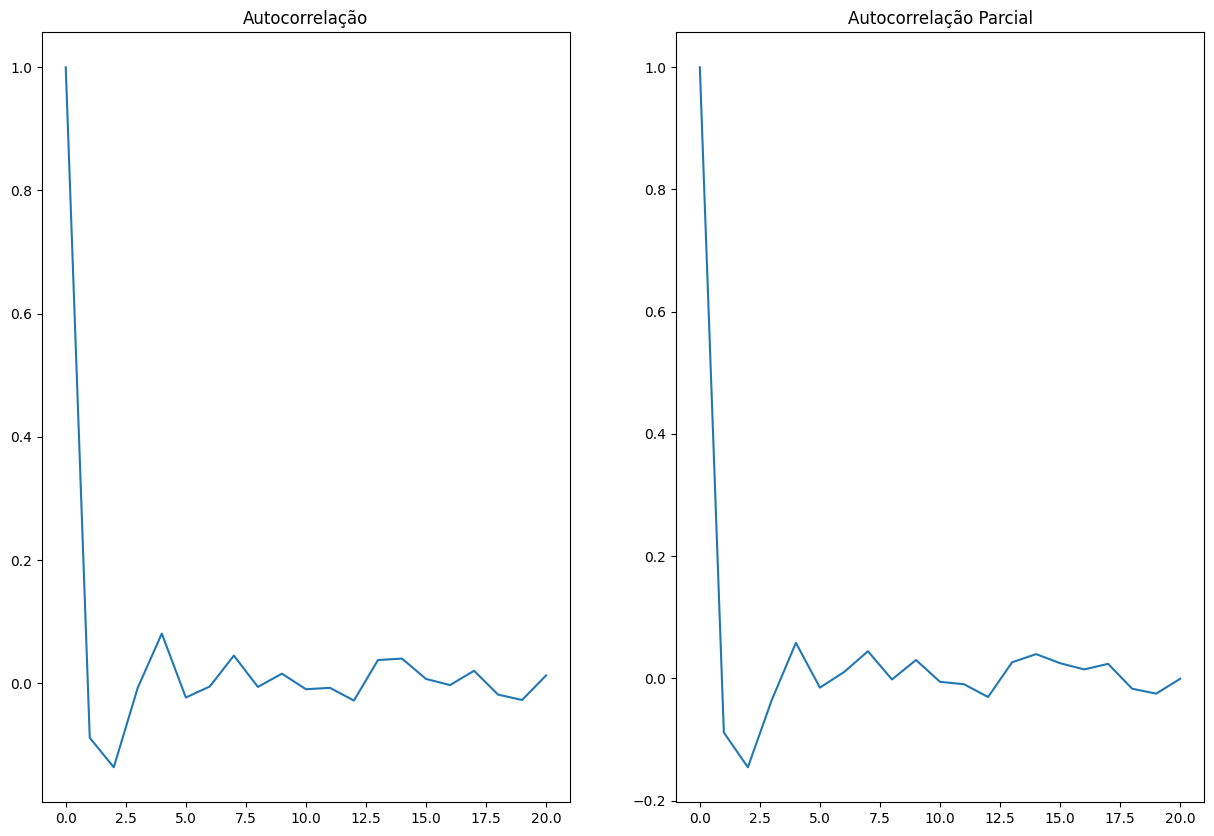

In [15]:
# Determinar parametro P

# Autocorrelacao e autocorrelacao parcial
lag_acf = acf(diferencial_tendencia_movel_log, nlags=20)
lag_pacf = pacf(diferencial_tendencia_movel_log, nlags=20)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.plot(lag_acf); ax1.set_title('Autocorrelação')
ax2.plot(lag_pacf); ax2.set_title('Autocorrelação Parcial')
plt.show()

In [16]:
# Modelo ARIMA
model = ARIMA(diferencial_tendencia_movel_log, order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())

data_fit = model_fit.fittedvalues
data_fit.index = diferencial_tendencia_movel_log.index

predicted_values = tendencia_movel_log.iloc[0] + np.cumsum(data_fit)

mape = mean_absolute_error(diferencial_tendencia_movel_log, predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

                               SARIMAX Results                                
Dep. Variable:                  Preco   No. Observations:                11205
Model:                 ARIMA(2, 1, 2)   Log Likelihood               24650.661
Date:                Thu, 18 Jul 2024   AIC                         -49291.323
Time:                        00:54:23   BIC                         -49254.702
Sample:                             0   HQIC                        -49278.997
                              - 11205                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0105      0.019    -51.956      0.000      -1.049      -0.972
ar.L2         -0.0993      0.004    -27.245      0.000      -0.106      -0.092
ma.L1         -0.0775      0.020     -3.958      0.0

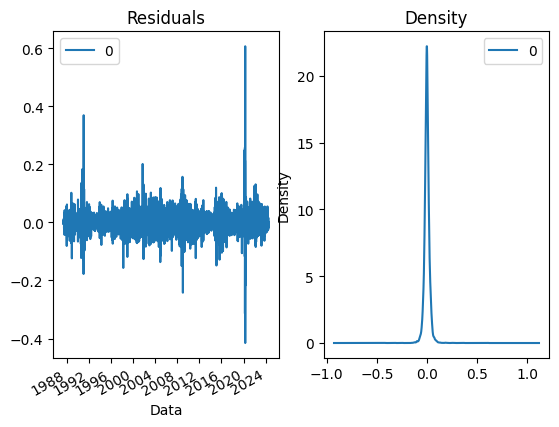

In [17]:
# Plotagem erro residual
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

### Modelo de Machine Learning - Prophet

In [18]:
# Modelo com Prophet


df_prophet = df_petroleo.copy()
df_prophet[['ds','y']] = df_petroleo[['Data','Preco']]

data_train = df_prophet.sample(frac=0.8, random_state=0)
data_test = df_prophet.drop(data_train.index)
#print(f'Base Treino : {data_train.shape}')
#print(f'Base Testes : {data_test.shape}')

data_train.info()
data_test.info()

modelo = Prophet(daily_seasonality=True)
modelo.fit(data_train)
df_predict = modelo.make_future_dataframe(periods=5, freq='D')
previsao = modelo.predict(df_predict)
previsao.tail()



DEBUG:cmdstanpy:input tempfile: /tmp/tmpfce95m3o/72qs28pf.json


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8970 entries, 2013-03-30 to 1994-02-18
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    8970 non-null   datetime64[ns]
 1   Preco   8970 non-null   float64       
 2   ds      8970 non-null   datetime64[ns]
 3   y       8970 non-null   float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 350.4 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2243 entries, 2024-07-15 to 1987-05-22
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    2243 non-null   datetime64[ns]
 1   Preco   2243 non-null   float64       
 2   ds      2243 non-null   datetime64[ns]
 3   y       2243 non-null   float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 87.6 KB


DEBUG:cmdstanpy:input tempfile: /tmp/tmpfce95m3o/5q3edoej.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70748', 'data', 'file=/tmp/tmpfce95m3o/72qs28pf.json', 'init=/tmp/tmpfce95m3o/5q3edoej.json', 'output', 'file=/tmp/tmpfce95m3o/prophet_modelxsbtffm_/prophet_model-20240718005425.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:54:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:54:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
8970,2024-07-13,91.66,79.18,106.42,91.66,91.66,0.90,0.90,0.90,-1.14,...,0.26,0.26,0.26,1.78,1.78,1.78,0.0,0.0,0.0,92.56
8971,2024-07-14,91.67,78.01,105.48,91.67,91.67,0.55,0.55,0.55,-1.14,...,-0.11,-0.11,-0.11,1.81,1.81,1.81,0.0,0.0,0.0,92.22
8972,2024-07-15,91.69,79.09,107.05,91.69,91.69,0.75,0.75,0.75,-1.14,...,0.06,0.06,0.06,1.83,1.83,1.83,0.0,0.0,0.0,92.43
8973,2024-07-16,91.70,78.96,106.69,91.70,91.70,0.61,0.61,0.61,-1.14,...,-0.11,-0.11,-0.11,1.86,1.86,1.86,0.0,0.0,0.0,92.31
8974,2024-07-17,91.72,78.77,105.57,91.72,91.72,0.73,0.73,0.73,-1.14,...,-0.01,-0.01,-0.01,1.89,1.89,1.89,0.0,0.0,0.0,92.45


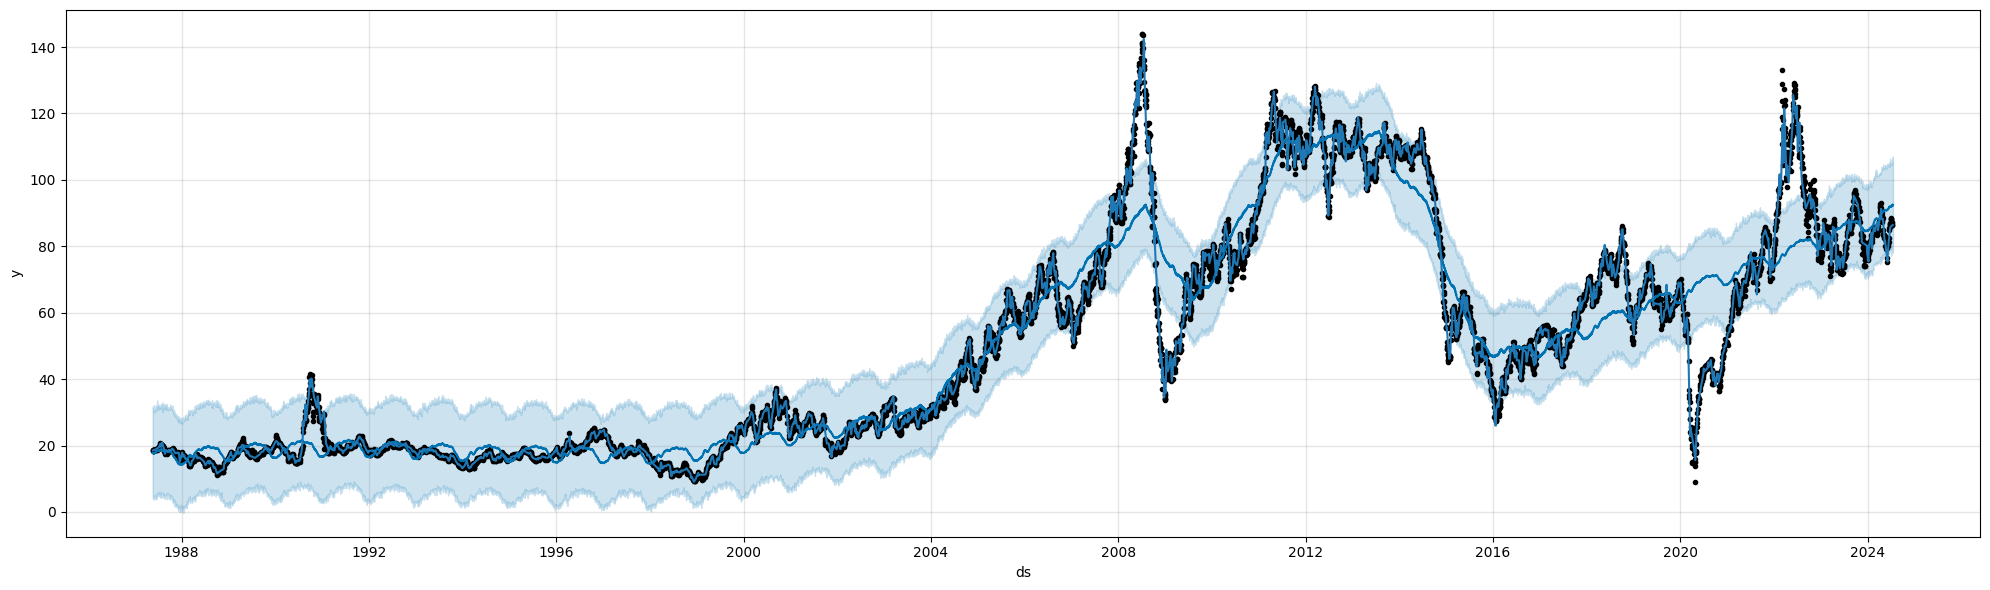

In [19]:
modelo.plot(previsao, figsize=(20,6));
plt.plot(data_test['ds'], data_test['y'])


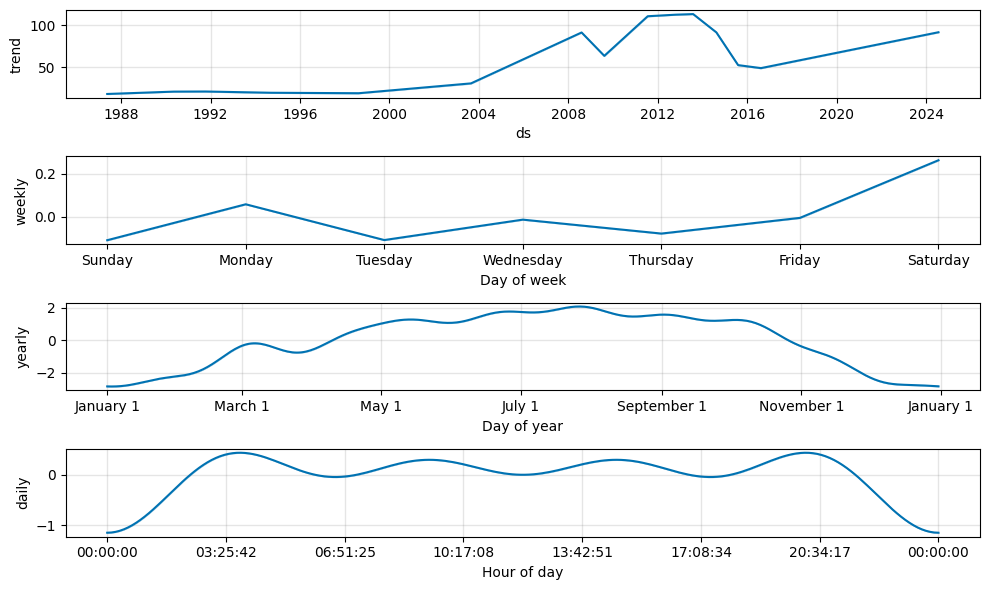

In [20]:
modelo.plot_components(previsao, figsize=(10,6));

In [21]:
modelo_changepoints = Prophet(n_changepoints=10, daily_seasonality=True)
modelo_changepoints.fit(data_train)
dataFramefuture = modelo_changepoints.make_future_dataframe(periods=5, freq='D')
previsao_changepoints = modelo_changepoints.predict(dataFramefuture)
previsao_changepoints.tail()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfce95m3o/vjjhf1v9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfce95m3o/rxerwobs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63072', 'data', 'file=/tmp/tmpfce95m3o/vjjhf1v9.json', 'init=/tmp/tmpfce95m3o/rxerwobs.json', 'output', 'file=/tmp/tmpfce95m3o/prophet_modeldrt7beki/prophet_model-20240718005450.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:54:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:54:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
8970,2024-07-13,94.29,79.78,110.47,94.29,94.29,0.71,0.71,0.71,-1.52,...,0.37,0.37,0.37,1.86,1.86,1.86,0.0,0.0,0.0,94.99
8971,2024-07-14,94.30,80.36,110.31,94.30,94.30,0.07,0.07,0.07,-1.52,...,-0.28,-0.28,-0.28,1.87,1.87,1.87,0.0,0.0,0.0,94.37
8972,2024-07-15,94.32,79.19,110.55,94.32,94.32,0.44,0.44,0.44,-1.52,...,0.07,0.07,0.07,1.89,1.89,1.89,0.0,0.0,0.0,94.76
8973,2024-07-16,94.34,78.82,108.93,94.34,94.34,0.28,0.28,0.28,-1.52,...,-0.10,-0.10,-0.10,1.91,1.91,1.91,0.0,0.0,0.0,94.62
8974,2024-07-17,94.35,78.00,109.65,94.35,94.35,0.35,0.35,0.35,-1.52,...,-0.05,-0.05,-0.05,1.92,1.92,1.92,0.0,0.0,0.0,94.71


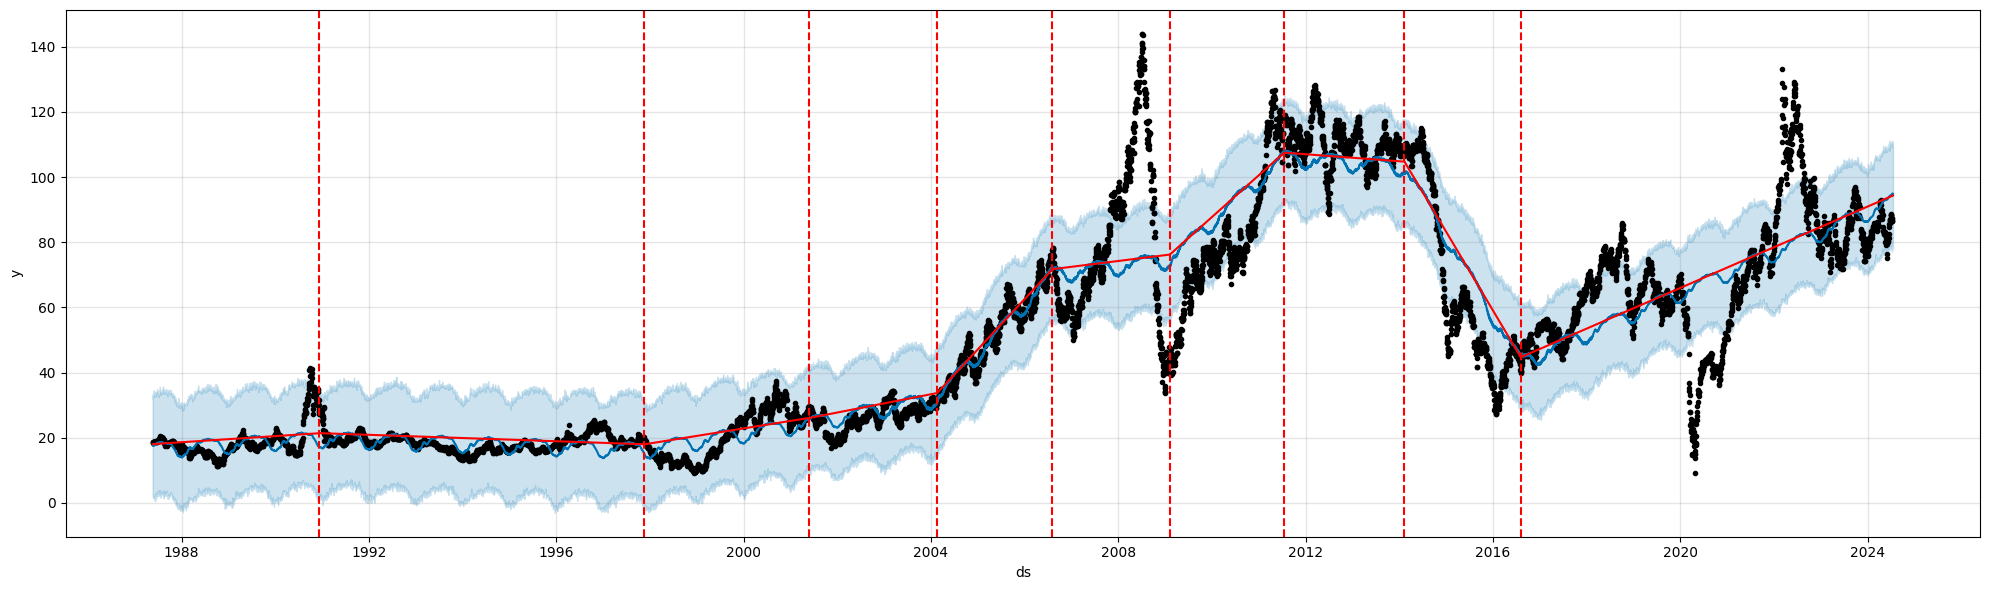

In [22]:
fig = modelo_changepoints.plot(previsao_changepoints, figsize=(20,6));
a = add_changepoints_to_plot(fig.gca(), modelo_changepoints, previsao_changepoints)

In [23]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = data_train[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 15.31%


In [ ]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(modelo, initial='365 days', period='90 days', horizon = '45 days')

INFO:prophet:Making 149 forecasts with cutoffs between 1987-12-09 00:00:00 and 2024-05-28 00:00:00


  0%|          | 0/149 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfce95m3o/bk_dic46.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfce95m3o/9bnjj74h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70225', 'data', 'file=/tmp/tmpfce95m3o/bk_dic46.json', 'init=/tmp/tmpfce95m3o/9bnjj74h.json', 'output', 'file=/tmp/tmpfce95m3o/prophet_modeldqcozv7o/prophet_model-20240718023129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:31:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:31:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfce95m3o/piugpvrg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfce95m3o/43hbkg0v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [25]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1988-10-20,12.97,12.41,13.54,13.50,1988-10-19
1,1988-10-21,12.97,12.40,13.56,13.48,1988-10-19
2,1988-10-24,12.89,12.28,13.45,12.20,1988-10-19
3,1988-10-25,12.84,12.27,13.37,12.08,1988-10-19
4,1988-10-26,12.75,12.17,13.30,12.08,1988-10-19
...,...,...,...,...,...,...
4375,2024-07-08,93.53,81.29,105.95,87.15,2024-04-13
4376,2024-07-09,93.39,80.12,106.85,86.48,2024-04-13
4377,2024-07-10,93.50,80.71,106.29,86.55,2024-04-13
4378,2024-07-11,93.46,80.74,106.88,86.49,2024-04-13
